In [1]:
import json
import pandas as pd
import re
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import cv2
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

/Users/saptarshimallikthakur/Desktop/Extraas/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df1 = pd.read_csv('GQA/sampled_gqa_data.csv')[['question', 'fullAnswer', 'imageId']]
df2 = pd.read_csv('GQA/sampled_gqa_data2.csv')[['question', 'fullAnswer', 'imageId']]
df12 = pd.concat([df1,df2]).reset_index(drop=True)
df12['imageId'] = df12['imageId'].apply(lambda x: 'GQA/resized_images/'+str(x)+'.jpg')
df12 = df12.rename(columns={'imageId':'img_path','question':'input_text','fullAnswer':'target_text'})
df12

input_text  \
0                              What is on the white wall?   
1                       What do you think is the pipe on?   
2          The pipe that is on the wall is of what color?   
3        Is there a pepper to the left of the white food?   
4       Is the racket in the top part or in the bottom...   
...                                                   ...   
343757                       Are there cars in the image?   
343758                              Is the jacket yellow?   
343759                         Do you see fences or cars?   
343760             Do the animals all have the same type?   
343761              Are the animals of different species?   

                                              target_text  \
0                                The pipe is on the wall.   
1                                The pipe is on the wall.   
2                                      The pipe is white.   
3       Yes, there are peppers to the left of the cheese.   
4                  The racket is in the top of the image.   
...                                                   ...   
343757                             No, there are no cars.   
343758                         Yes, the jacket is yellow.   
343759                   No, there are no cars or fences.   
343760                    Yes, all the animals are bears.   
343761                     No, all the animals are bears.   

                              img_path  
0       GQA/resized_images/2375429.jpg  
1       GQA/resized_images/2375429.jpg  
2       GQA/resized_images/2375429.jpg  
3       GQA/resized_images/2347293.jpg  
4       GQA/resized_images/2356586.jpg  
...                                ...  
343757  GQA/resized_images/2355824.jpg  
343758  GQA/resized_images/2330632.jpg  
343759  GQA/resized_images/2394615.jpg  
343760  GQA/resized_images/2315749.jpg  
343761  GQA/resized_images/2315749.jpg  

[343762 rows x 3 columns]

In [3]:
# Open and read the JSON file  https://huggingface.co/datasets/liuhaotian/LLaVA-Pretrain
with open("blip images/blip_laion_cc_sbu_558k.json", "r") as file:
    data = json.load(file)  # Parse the JSON data into a Python dictionary

# Convert to DataFrame
df3 = pd.DataFrame([{
    'id': item['id'],
    'img_path': 'blip images/images/'+item['image'],
    'input_text': next(conv['value'] for conv in item['conversations'] if conv['from'] == 'human'),
    'target_text': next(conv['value'] for conv in item['conversations'] if conv['from'] == 'gpt')
} for item in data]).dropna().reset_index(drop=True)

df3['input_text'] = None

question_pool = [
    'Render a clear and concise summary of the photo.\n<image>',
    'Write a terse but informative summary of the picture.\n<image>',
    '<image>\nWhat is this?',
    '<image>\nRender a clear and concise summary of the photo.',
    'What is in the photo?\n<image>',
    'Describe the image concisely.\n<image>',
    'Share a concise interpretation of the image provided.\n<image>',
    'Give a brief description of the image.\n<image>',
    "<image>\nPresent a compact description of the photo's key features.",
    '<image>\nDescribe the image concisely.', 'What is this?\n<image>',
    '<image>\nWrite a terse but informative summary of the picture.',
    'Provide a brief description of the given image.\n<image>',
    'Summarize the visual content of the image.\n<image>',
    '<image>\nWhat is in the photo?',
    '<image>\nProvide a brief description of the given image.',
    "Present a compact description of the photo's key features.\n<image>",
    'Give a short and clear explanation of the subsequent image.\n<image>',
    '<image>\nGive a short and clear explanation of the subsequent image.',
    '<image>\nGive a brief description of the image.',
    '<image>\nSummarize the visual content of the image.',
    '<image>\nShare a concise interpretation of the image provided.'
    "What is present in the image?",
    "How would you describe the background setting?",
    "What is the central subject or point of focus?",
    "What is happening in the image?",
    "Where might this photo have been taken?",
    "Describe the image.",
    "Are there people in the picture?",
    "Is there an animal in the picture?",
    "What objects are visible in the image?",
    "What activity or event is occurring in the image?",
    "Can you describe the colors present in the image?",
    "What do you think the mood or atmosphere of the image is?",
    "What draws your attention most in the image?",
    "Does the image appear to be candid or posed?",
    "Is there any text or signage visible in the image?",
    "Are there any buildings or structures visible?",
    "Does the image convey any emotions or feelings?",
    "Are there any artistic or stylistic elements in the photo?",
    "If you could give this image a title, what would it be?",
    'What is unique about the image?',
]

# Assign questions per img_path group
for img_path, group in df3.groupby('img_path'):
    indices = group.index.tolist()
    available_questions = question_pool.copy()
    np.random.shuffle(available_questions)
    
    # If more rows than questions, cycle through questions
    while len(available_questions) < len(indices):
        extra = question_pool.copy()
        np.random.shuffle(extra)
        available_questions += extra

    for i, idx in enumerate(indices):
        df3.at[idx, 'input_text'] = available_questions[i]
df3 = df3[['img_path','target_text','input_text']]
df3

img_path  \
0       blip images/images/00453/004539375.jpg   
1       blip images/images/00223/002239345.jpg   
2       blip images/images/00594/005947502.jpg   
3       blip images/images/00511/005116462.jpg   
4       blip images/images/00201/002017886.jpg   
...                                        ...   
558123  blip images/images/00052/000524806.jpg   
558124  blip images/images/00375/003755035.jpg   
558125  blip images/images/00217/002176227.jpg   
558126  blip images/images/00060/000600956.jpg   
558127  blip images/images/00099/000992146.jpg   

                                              target_text  \
0       select luxury furniture 3 - inch gel memory fo...   
1                   a grey watch with an army style strap   
2       a dragon kite flying in the blue sky stock images   
3       $ 10 - cute cheap printed mini dress - khaki m...   
4         augmented reality using aruco markers in opencv   
...                                                   ...   
558123  paper quilled letters of the alphabet h with c...   
558124  a jabra corded headset with usb sync, power co...   
558125  an apple ii computer, with a computer monitor ...   
558126  us03498792 figure 1 from a patent drawing of a...   
558127            how to draw odin from vikings - step 11   

                                               input_text  
0          Are there any buildings or structures visible?  
1       Present a compact description of the photo's k...  
2       Write a terse but informative summary of the p...  
3         <image>\nGive a brief description of the image.  
4       <image>\nShare a concise interpretation of the...  
...                                                   ...  
558123                     What is in the photo?\n<image>  
558124  <image>\nShare a concise interpretation of the...  
558125  <image>\nWrite a terse but informative summary...  
558126                 Is there an animal in the picture?  
558127                             What is this?\n<image>  

[558128 rows x 3 columns]

In [4]:
with open('fsvqa/fsvqa_original/fsvqa_original_train_questions.json', 'r') as f:
    data = json.load(f)

# 'questions' is expected to be a list of dictionaries
questions = data['questions']

# Convert list of dicts to DataFrame
df1 = pd.DataFrame(questions)[['img_id', 'question', 'question_id']]
df1.reset_index(drop=True, inplace=True)

# Step 1: Load the raw JSON structure
with open('fsvqa/fsvqa_original/fsvqa_original_train_annotations.json', 'r') as f:
    data = json.load(f)

# Step 2: Extract the list of annotation dicts
annotations = data['annotations']  # each item contains 'question_id' and 'answers'

# Step 3: Flatten the data
# Each annotation contains a list of 'answers', so we need to explode that
flat_data = []
for ann in annotations:
    question_id = ann['question_id']
    img_id = ann['img_id']
    for ans in ann['answers']:
        flat_data.append({
            'question_id': question_id,
            'img_id': img_id,
            'answer': ans['answer']
        })

# Step 4: Convert to DataFrame
df2 = pd.DataFrame(flat_data)

# Optional: Reset index and show a few rows
df2.reset_index(drop=True, inplace=True)

df4 = pd.merge(df1,df2,how='left',on='question_id').drop(columns=['img_id_y']).rename(columns={'img_id_x': 'img_id'})
df4 = df4.sort_values(by='img_id').reset_index(drop=True)[['img_id','question','answer']]
df4['img_id'] = df4['img_id'].apply(lambda x: 'fsvqa/train2014/'+str(x)+'.jpg')
df4 = df4.rename(columns={'img_id':'img_path','question':'input_text','answer':'target_text'})
df4

img_path                              input_text  \
0            fsvqa/train2014/9.jpg                What is the green stuff?   
1            fsvqa/train2014/9.jpg           How many cookies can be seen?   
2            fsvqa/train2014/9.jpg              What color are the dishes?   
3           fsvqa/train2014/25.jpg             Are both giraffes standing?   
4           fsvqa/train2014/25.jpg                   Where is the giraffe?   
...                            ...                                     ...   
248344  fsvqa/train2014/581909.jpg              Is this boat in the water?   
248345  fsvqa/train2014/581909.jpg                 Are there storm clouds?   
248346  fsvqa/train2014/581921.jpg                       Is the snow deep?   
248347  fsvqa/train2014/581921.jpg    Is there a lot of snow on the floor?   
248348  fsvqa/train2014/581921.jpg  What sport is being demonstrated here?   

                                      target_text  
0                    The green stuff is broccoli.  
1                          2 cookies can be seen.  
2                 The dishes are pink and yellow.  
3             No, both giraffes are not standing.  
4                    The giraffe is at near tree.  
...                                           ...  
248344         No, this boat is not in the water.  
248345               Yes, there are storm clouds.  
248346                     Yes, the snow is deep.  
248347  Yes, there is a lot of snow on the floor.  
248348   Snowboarding is being demonstrated here.  

[248349 rows x 3 columns]

In [5]:
df = pd.concat([df12,df3,df4])[['input_text','target_text','img_path']].reset_index(drop=True)
del(df1)
del(df2)
del(df3)
del(df12)
del(df4)
df

input_text  \
0                               What is on the white wall?   
1                        What do you think is the pipe on?   
2           The pipe that is on the wall is of what color?   
3         Is there a pepper to the left of the white food?   
4        Is the racket in the top part or in the bottom...   
...                                                    ...   
1150234                         Is this boat in the water?   
1150235                            Are there storm clouds?   
1150236                                  Is the snow deep?   
1150237               Is there a lot of snow on the floor?   
1150238             What sport is being demonstrated here?   

                                               target_text  \
0                                 The pipe is on the wall.   
1                                 The pipe is on the wall.   
2                                       The pipe is white.   
3        Yes, there are peppers to the left of the cheese.   
4                   The racket is in the top of the image.   
...                                                    ...   
1150234                 No, this boat is not in the water.   
1150235                       Yes, there are storm clouds.   
1150236                             Yes, the snow is deep.   
1150237          Yes, there is a lot of snow on the floor.   
1150238           Snowboarding is being demonstrated here.   

                               img_path  
0        GQA/resized_images/2375429.jpg  
1        GQA/resized_images/2375429.jpg  
2        GQA/resized_images/2375429.jpg  
3        GQA/resized_images/2347293.jpg  
4        GQA/resized_images/2356586.jpg  
...                                 ...  
1150234      fsvqa/train2014/581909.jpg  
1150235      fsvqa/train2014/581909.jpg  
1150236      fsvqa/train2014/581921.jpg  
1150237      fsvqa/train2014/581921.jpg  
1150238      fsvqa/train2014/581921.jpg  

[1150239 rows x 3 columns]

In [6]:
df.isnull().sum()

input_text     0
target_text    0
img_path       0
dtype: int64

# Cleaning !

In [7]:
# 1) Text cleaning ------------------------------------------------------
def clean_text(text: str) -> str:
    """
    Remove HTML, normalize whitespace, preserve punctuation/numbers/casing.
    """
    # text = text.lower()
    text = re.sub(r'<image>', '', text, flags=re.IGNORECASE)
    text = re.sub(r'[^a-zA-Z0-9.,!?]+', ' ', text)
    text = text.replace('\r', ' ').replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text)
    return text.strip().lower()

df['target_text'] = df['target_text'].apply(lambda x: clean_text(x))
df['input_text'] = df['input_text'].apply(lambda x: clean_text(x))

In [8]:
# Combine summary + dialogue and split on whitespace
raw_lens = [
    len(f"{s} {d}".split()) 
    for s, d in tqdm(zip(df['target_text'], df['input_text']), total=len(df))
]

lens = np.array(raw_lens)

# Print summary stats
def pct(x): return np.percentile(lens, x)

print(f"Total examples    : {len(lens):,}")
print(f"Min / Max words   : {lens.min()} / {lens.max()}")
print(f"Mean ± std        : {lens.mean():.1f} ± {lens.std():.1f}")
print("--- Percentiles (word count per raw text pair) ---")
for p in [50, 90, 95, 98, 99]:
    print(f"{p:>3}% : {pct(p):.0f} words")

del(raw_lens)

100%|██████████| 1150239/1150239 [00:00<00:00, 1506409.77it/s]


Total examples    : 1,150,239
Min / Max words   : 3 / 44
Mean ± std        : 15.6 ± 5.0
--- Percentiles (word count per raw text pair) ---
 50% : 15 words
 90% : 22 words
 95% : 25 words
 98% : 27 words
 99% : 29 words


In [9]:
MAX_LEN = int(pct(99))

text_pairs = []

for img,i,j in zip(df.img_path,df.input_text,df.target_text):
    try:
        if len(i.split(" ")+j.split(" ")) < MAX_LEN: 
            text_pairs.append((img,i,j))
    except:
        pass

len(text_pairs), text_pairs[:5]

(1138490,
 [('GQA/resized_images/2375429.jpg',
   'what is on the white wall?',
   'the pipe is on the wall.'),
  ('GQA/resized_images/2375429.jpg',
   'what do you think is the pipe on?',
   'the pipe is on the wall.'),
  ('GQA/resized_images/2375429.jpg',
   'the pipe that is on the wall is of what color?',
   'the pipe is white.'),
  ('GQA/resized_images/2347293.jpg',
   'is there a pepper to the left of the white food?',
   'yes, there are peppers to the left of the cheese.'),
  ('GQA/resized_images/2356586.jpg',
   'is the racket in the top part or in the bottom of the image?',
   'the racket is in the top of the image.')])

# IMAGE EMBEDDER

In [10]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Layer, Reshape

# Load the frozen SavedModel from disk
saved_model_path = 'mobilevit-tensorflow2-xxs-1k-256-fe-v1'
loaded_model = tf.saved_model.load(saved_model_path)
encode_fn = loaded_model.signatures['serving_default']

# Wrap the SavedModel call in a custom Keras layer
class FrozenEncoder(Layer):
    def call(self, inputs):
        outputs = encode_fn(inputs)
        return outputs['features_swish']  # returns [B, H, W, C]

# Build a Keras model with the encoder
def build_image_encoder():
    input_tensor = Input(shape=(256, 256, 3))
    feat_map = FrozenEncoder()(input_tensor)  # [B, H, W, C]
    shape = feat_map.shape
    reshaped = Reshape((shape[1] * shape[2], shape[3]))(feat_map)  # [B, HW, C]
    return Model(inputs=input_tensor, outputs=reshaped)

# Image preprocessing function
def decode_and_resize(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = tf.cast(img, tf.float32) / 255.0
    return img

# Build the encoder model
model = build_image_encoder()

# Prepare image batch
paths = tf.constant([
    "/Users/saptarshimallikthakur/Desktop/imgs/Screenshot 2025-06-08 at 7.36.42 AM.png",
    "/Users/saptarshimallikthakur/Desktop/imgs/girraffe.jpg"
])
images = tf.map_fn(decode_and_resize, paths, fn_output_signature=tf.float32)

# Extract features
v3_output = model(images, training=False)
print("Feature shape:", v3_output.shape)

2025-06-11 00:05:28.273742: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-06-11 00:05:28.273765: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-06-11 00:05:28.273769: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
I0000 00:00:1749580528.273780 9567701 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1749580528.273800 9567701 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-06-11 00:05:36.151332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Feature shape: (2, 64, 320)


# Tokenizing

In [11]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers.processors import TemplateProcessing
from tokenizers import models, trainers, pre_tokenizers

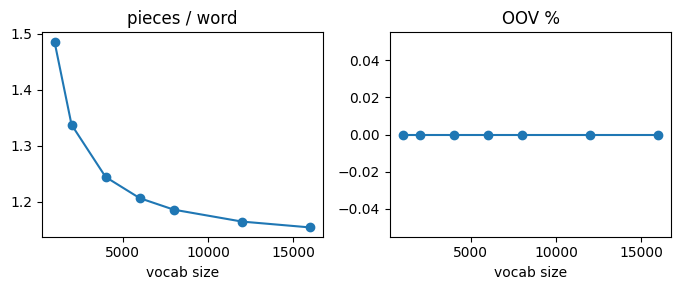

In [12]:
# ── assume train_df already loaded ─────────────────────────────────────
rng            = np.random.default_rng(42)
valid_mask     = rng.random(len(df)) < 0.25          # 25 % hold-out
train_df_, valid_df = df[~valid_mask], df[valid_mask]

# ⇢ cache validation texts so we can loop over them many times
valid_texts = [f"{s} {d}" for s, d in zip(valid_df["input_text"], valid_df["target_text"])]

def train_tokenizer(text_iter, vocab_size: int) -> Tokenizer:
    tok = Tokenizer(models.BPE(unk_token="[UNK]"))
    tok.pre_tokenizer = pre_tokenizers.Whitespace()
    trainer = trainers.BpeTrainer(vocab_size=vocab_size,
                                  min_frequency=2,
                                  special_tokens=["[UNK]"])
    tok.train_from_iterator(text_iter, trainer)
    return tok

def avg_pieces_per_word(tok: Tokenizer, texts) -> float:
    pieces = words = 0
    for t in texts:
        ids   = tok.encode(t).ids
        pieces += len(ids)
        words  += len(t.split())
    return pieces / words

vocab_sizes = [1000,2000,4000,6000,8000,12000,16000]
pieces_per_word, oov_rate = [], []

for k in vocab_sizes:
    train_iter = (f"{s} {d}" for s, d in
                  zip(train_df_["input_text"], train_df_["target_text"]))
    tok = train_tokenizer(train_iter, k)

    # 1) average sub-words per word on validation set
    pieces_per_word.append(avg_pieces_per_word(tok, valid_texts))

    # 2) OOV percentage on validation set
    unk_id = tok.token_to_id("[UNK]")
    total = unk = 0
    for t in valid_texts:
        ids   = tok.encode(t).ids
        total += len(ids)
        unk   += sum(id_ == unk_id for id_ in ids)
    oov_rate.append(100 * unk / total)

# ── plot ───────────────────────────────────────────────────────────────
plt.figure(figsize=(7,3))

plt.subplot(1,2,1)
plt.plot(vocab_sizes, pieces_per_word, marker='o')
plt.title("pieces / word"); plt.xlabel("vocab size")

plt.subplot(1,2,2)
plt.plot(vocab_sizes, oov_rate, marker='o')
plt.title("OOV %"); plt.xlabel("vocab size")

plt.tight_layout(); plt.show()

In [13]:
VOCAB_SIZE = 8000

CORPUS_FILE = 'all_texts.txt'
SPECIAL_TOKENS = ['[PAD]','[UNK]','[BOS]','[EOS]','[SEP]']  

with open(CORPUS_FILE, 'w', encoding='utf-8') as f:
    for _, row in df.iterrows():
        f.write(str(row['input_text']) + ' ' + str(row['target_text']) + '\n')

100%|██████████| 1150239/1150239 [00:32<00:00, 35805.00it/s]


Total samples    : 1,150,239
Min / Max tokens : 7 / 93
Mean ± std       : 21.5 ± 5.6
--- percentiles (tokens) ---
 50% : 21
 90% : 29
 95% : 32
 98% : 35
 99% : 37


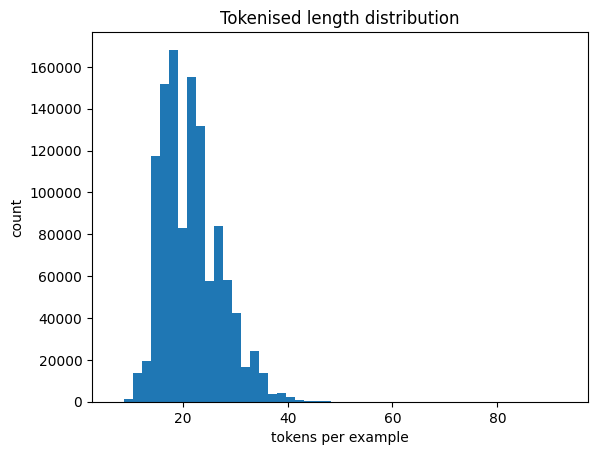

In [14]:
# Initialize and train
tokenizer = Tokenizer(BPE(unk_token='[UNK]'))
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=SPECIAL_TOKENS)
tokenizer.train([CORPUS_FILE], trainer)

# 3) Configure post-processing, padding & truncation ------------------
pad_id = tokenizer.token_to_id('[PAD]')
unk_id = tokenizer.token_to_id('[UNK]')
bos_id = tokenizer.token_to_id('[BOS]')
eos_id = tokenizer.token_to_id('[EOS]')
sep_id = tokenizer.token_to_id('[SEP]')

# Add BOS/EOS around single sequences
tokenizer.post_processor = TemplateProcessing(
    single='[BOS] $A [SEP]',
    pair='[BOS] $A [SEP] $B [EOS]',
    special_tokens=[('[BOS]', bos_id), ('[EOS]', eos_id),('[SEP]', sep_id)]
)

# 0)  Make sure `tok` points to the FINAL tokenizer
#     → trained on the full corpus with your chosen vocab_size
# ------------------------------------------------------------
tok = tokenizer          # whatever variable you use

# ------------------------------------------------------------
# 1)  Get token counts for every example
#     (here: concatenate summary + dialogue; split if you want)
# ------------------------------------------------------------
lens = []

for s, d in tqdm(zip(df["input_text"], df["target_text"]),
                 total=len(df)):
    ids   = tok.encode(f'{s}',f'{d}').ids
    lens.append(len(ids))

lens = np.array(lens)

# ------------------------------------------------------------
# 2)  Print key stats
# ------------------------------------------------------------
def pct(x): return np.percentile(lens, x)

print(f"Total samples    : {len(lens):,}")
print(f"Min / Max tokens : {lens.min()} / {lens.max()}")
print(f"Mean ± std       : {lens.mean():.1f} ± {lens.std():.1f}")
print("--- percentiles (tokens) ---")
for p in (50, 90, 95, 98, 99):
    print(f"{p:>3}% : {pct(p):.0f}")

# ------------------------------------------------------------
# 3)  Quick histogram    (no seaborn, single plot, no colors set)
# ------------------------------------------------------------
plt.hist(lens, bins=50)
plt.xlabel("tokens per example")
plt.ylabel("count")
plt.title("Tokenised length distribution")
plt.show()

In [15]:
BATCH_SIZE = 64
MAX_LEN = int(pct(99))
del(lens)

# 0) Configure your tokenizer *once* at startup, not per-example
tokenizer.enable_truncation(
    max_length=MAX_LEN
)

tokenizer.enable_padding(
    pad_id=pad_id,
    pad_token='[PAD]',
    length=MAX_LEN
)

def encode_text(texts):
    encodings = tokenizer.encode(texts).ids
    return np.array(encodings, dtype=np.int32)

# 1) encode_pair → return a NumPy array
def encode_pair(text_a: str, text_b: str) -> np.ndarray:
    enc = tokenizer.encode(text_a, text_b).ids
    return np.array(enc, dtype=np.int32)   # shape: [MAX_LEN]

def encode_example(img_path, text: str, summary: str):
    ids = encode_pair(text, summary)           # np.ndarray, shape=[MAX_LEN]
    labels = np.concatenate([ids[1:], [pad_id]])  # shape=[MAX_LEN]

    # find SEP
    sep_idxs = np.where(labels == sep_id)[0]
    sep_pos = int(sep_idxs[0]) if sep_idxs.size else len(ids)

    # build base mask: 1 only for positions > sep_pos AND not PAD
    positions = np.arange(len(labels))
    loss_mask = (positions > sep_pos).astype(np.float32) * (labels != pad_id).astype(np.float32)

    return img_path, ids, labels.astype(np.int32), loss_mask

# ── 0. do *all* tokenisation once ──────────────────────────
triples = [encode_example(img, t, s) for (img, t, s) in text_pairs]   # Python loop, done **once**
img_path, ids, labels, masks = map(lambda k: tf.constant(np.stack(k, 0)),zip(*triples))                      # shapes [N, MAX_LEN]

# ── 1. build the purely-TF dataset ─────────────────────────
ds = (
    tf.data.Dataset.from_tensor_slices({'img_path':img_path,"input_ids": ids, "labels": labels, "loss_mask": masks})
    .shuffle(len(text_pairs))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

del(triples)
del(img_path)
del(ids)
del(labels)
del(masks)

In [16]:
# Get the full vocab: token → id
vocab_dict = tokenizer.get_vocab()

# To sort it by ID (optional, for better readability)
sorted_vocab = dict(sorted(vocab_dict.items(), key=lambda item: item[1]))
print(sorted_vocab)

del(vocab_dict)
del(sorted_vocab)

{'[PAD]': 0, '[UNK]': 1, '[BOS]': 2, '[EOS]': 3, '[SEP]': 4, '!': 5, ',': 6, '.': 7, '0': 8, '1': 9, '2': 10, '3': 11, '4': 12, '5': 13, '6': 14, '7': 15, '8': 16, '9': 17, '?': 18, 'a': 19, 'b': 20, 'c': 21, 'd': 22, 'e': 23, 'f': 24, 'g': 25, 'h': 26, 'i': 27, 'j': 28, 'k': 29, 'l': 30, 'm': 31, 'n': 32, 'o': 33, 'p': 34, 'q': 35, 'r': 36, 's': 37, 't': 38, 'u': 39, 'v': 40, 'w': 41, 'x': 42, 'y': 43, 'z': 44, 'th': 45, 'the': 46, 're': 47, 'is': 48, 'in': 49, 'an': 50, 'at': 51, 'on': 52, 'or': 53, 'es': 54, 'ma': 55, 'of': 56, 'er': 57, 'en': 58, 'le': 59, 'ge': 60, 'wh': 61, 'ar': 62, 'to': 63, 'ima': 64, 'ing': 65, 'are': 66, 'ri': 67, 'image': 68, 'there': 69, 'ou': 70, 'it': 71, 'no': 72, 'what': 73, 'and': 74, 'ho': 75, 'ic': 76, 'ac': 77, 'se': 78, 'al': 79, 'st': 80, 'ion': 81, 'do': 82, 'ro': 83, 'co': 84, 've': 85, 'ent': 86, 'be': 87, 'this': 88, 'ra': 89, 'su': 90, 'lo': 91, 'wi': 92, 'bo': 93, 'ure': 94, 'de': 95, 'des': 96, 'sh': 97, 'ir': 98, 'ch': 99, 'pho': 100, 'ph

In [17]:
vocab = tokenizer.get_vocab()           # indices 0 … V

id_to_token = {idx: tok for tok, idx in vocab.items()}

# 2) Decoder: drop PADs
def decode_token_ids(token_ids: list[int]) -> str:
    tokens = []
    for tid in token_ids:
        if tid == pad_id:
            continue
        tok = id_to_token.get(tid, '?')
        if tok.startswith('Ġ'):
            tok = tok[1:]  # Remove the space prefix indicator
            tokens.append(' ' + tok)
        else:
            tokens.append(tok)
    return ' '.join(tokens).strip()

# 3) Inspect one batch from your TF dataset
for batch in ds.take(10):
    pth = batch['img_path'].numpy()
    input_ids = batch['input_ids'].numpy()  # shape (batch, MAX_LEN)
    labels    = batch['labels'].numpy()

    for i, (pth, ids_row, lbl_row) in enumerate(zip(pth, input_ids, labels), start=1):
        print(f"\n🟢 Sample {i}")
        print("  pth: ", pth)
        print("  Input IDs: ", ids_row.tolist())
        print("  Decoded:   ", decode_token_ids(ids_row.tolist()))
        print("  Label IDs: ", lbl_row.tolist())


🟢 Sample 1
  pth:  b'blip images/images/00132/001322827.jpg'
  Input IDs:  [2, 172, 46, 68, 539, 115, 548, 53, 551, 18, 4, 46, 7995, 56, 46, 562, 48, 84, 1183, 1868, 56, 80, 7988, 74, 46, 384, 233, 622, 3, 0, 0, 0, 0, 0, 0, 0, 0]
  Decoded:    [BOS] does the image convey any emotions or feelings ? [SEP] the choir of the ep is co pal church of st luke and the lu ther ans [EOS]
  Label IDs:  [172, 46, 68, 539, 115, 548, 53, 551, 18, 4, 46, 7995, 56, 46, 562, 48, 84, 1183, 1868, 56, 80, 7988, 74, 46, 384, 233, 622, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]

🟢 Sample 2
  pth:  b'blip images/images/00174/001742929.jpg'
  Input IDs:  [2, 73, 82, 117, 431, 46, 558, 53, 566, 56, 46, 68, 48, 18, 4, 4266, 1883, 739, 1821, 3208, 917, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  Decoded:    [BOS] what do you think the mood or atmosphere of the image is ? [SEP] miller beer bottle ko oz ie [EOS]
  Label IDs:  [73, 82, 117, 431, 46, 558, 53, 566, 56, 46, 68, 48, 18, 4, 4266, 1883, 739, 1821, 3208, 917, 3, 

2025-06-11 00:08:47.083335: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
for batch in ds.take(1):
    input_ids = batch["input_ids"]
    labels    = batch["labels"]
    loss_mask = batch["loss_mask"]
    
j=19
print(loss_mask[j])
print('\n',decode_token_ids(batch["labels"][j].numpy()))
print('\n',decode_token_ids(batch["input_ids"][j].numpy()))

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(37,), dtype=float32)

 give a brief description of the image . [SEP] sti hel pet rol chain saw [EOS]

 [BOS] give a brief description of the image . [SEP] sti hel pet rol chain saw [EOS]


2025-06-11 00:08:48.646878: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Llama Architecture !

In [19]:
def apply_rope(x, sin, cos):
    """
    x   : (B, h, T, d) even-sized last dim (d must be multiple of 2)
    sin : (T, d//2)     broadcastable
    cos : (T, d//2)
    """
    #This separates each feature vector's dimensions into 2 halves — like real and imaginary parts.
    x_even = x[..., 0::2]      # Get even-dimension values → shape: (B, h, T, d/2)
    x_odd  = x[..., 1::2]      # Get odd-dimension values → shape: (B, h, T, d/2)

    # This is a 2D rotation formula applied to each positional index and head.
    # It "rotates" the embedding vector in its dimensional space based on position.
    x_rot_even =  x_even *  cos - x_odd * sin
    x_rot_odd  =  x_even *  sin + x_odd * cos
    
    # interleave even/odd back together
    x_rot = tf.stack([x_rot_even, x_rot_odd], axis=-1)   # (..., d/2, 2)
    return tf.reshape(x_rot, tf.shape(x))                # (..., d)

def make_sincos(seq_len, dim, base=10000):
    '''
    Returns sin, cos with shape (seq_len, dim//2)
    '''
    pos = tf.cast(tf.range(seq_len), tf.float32)                       # (T,)
    i   = tf.cast(tf.range(0, dim, 2), tf.float32) / dim              # (d/2,)
    theta = pos[:, None] / (base ** i[None, :])                       # (T, d/2)
    return tf.sin(theta), tf.cos(theta)

class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Vanilla multi-head (scaled-dot-product) attention implemented from scratch.

    Args
    ----
    d_model     : int   – total embedding size (must be divisible by num_heads)  
    num_heads   : int   – number of attention heads  
    dropout     : float – dropout on attention weights (0.0 = no dropout)

    Call Signature
    --------------
    output, attn_scores = mha(
        query,                     # (B, T_q, d_model)
        value=None,                # (B, T_v, d_model)  – defaults to query
        key=None,                  # (B, T_k, d_model)  – defaults to value
        mask=None,                 # (B, 1, T_q, T_k) or (B, T_q, T_k)
        use_causal_mask=False,     #  True → autoregressive causal mask
        training=None
    )
    """
    def __init__(self, d_model, num_heads, dropout=0.0, **kwargs):
        super().__init__(**kwargs)
        if d_model % num_heads != 0:
            raise ValueError(
                f"d_model={d_model} must be divisible by num_heads={num_heads}"
            )

        self.d_model   = d_model
        self.num_heads = num_heads
        self.depth     = d_model // num_heads

        # Linear projections for Q, K, V and final output
        self.wq   = tf.keras.layers.Dense(d_model, use_bias=False)
        self.wk   = tf.keras.layers.Dense(d_model, use_bias=False)
        self.wv   = tf.keras.layers.Dense(d_model, use_bias=False)
        self.wo   = tf.keras.layers.Dense(d_model, use_bias=False)

        self.dropout = tf.keras.layers.Dropout(dropout)

    # ────────────────────────────────────────────────────────────────────────
    # Helpers
    # ────────────────────────────────────────────────────────────────────────
    def _split_heads(self, x, B):
        """
        Reshape (B, T, d_model) → (B, num_heads, T, depth)
        so we can run attention on each head in parallel.
        """
        x = tf.reshape(x, (B, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    @staticmethod
    def _scaled_dot_product_attention(q, k, v, mask, dropout,training=None):
        """
        Core attention: softmax(QKᵀ / √d_k) V
        Returns: (B, h, T_q, depth_v), (B, h, T_q, T_k)
        """
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scores = tf.matmul(q, k, transpose_b=True) / tf.math.sqrt(dk)  # (B,h,T_q,T_k)

        if mask is not None:
            # broadcast automatically if mask rank < scores rank
            scores += (mask * -1e9)  # large negative → zero probability

        attn = tf.nn.softmax(scores, axis=-1)
        attn = dropout(attn,training=training)
        output = tf.matmul(attn, v)  # (B,h,T_q,depth)
        return output

    # ────────────────────────────────────────────────────────────────────────
    # Forward pass
    # ────────────────────────────────────────────────────────────────────────
    def call(
        self,
        query,
        value=None,
        key=None,
        mask=None,
        use_causal_mask=False,
        training=None,
        self_attention=False
    ):
        if value is None:
            value = query
        if key is None:
            key = value

        B = tf.shape(query)[0]
        Tq = tf.shape(query)[1]          # sequence length of Q
        Tk = tf.shape(key)[1]

        # 1. Linear projections
        q = self.wq(query)   # (B, T_q, d_model)
        k = self.wk(key)     # (B, T_k, d_model)
        v = self.wv(value)   # (B, T_v, d_model)

        # 2. Reshape for multi-head
        q = self._split_heads(q, B)  # (B, h, T_q, depth)
        k = self._split_heads(k, B)  # (B, h, T_k, depth)
        v = self._split_heads(v, B)  # (B, h, T_v, depth)

        # 3) -----------------  ROTARY  -----------------
        # Build sin/cos for the longest sequence we need this step
        max_len = tf.maximum(Tq, Tk)
        sin, cos = make_sincos(max_len, self.depth)       # depth = d_model / num_heads

        # Slice sin/cos to actual lengths (broadcast works automatically)
        # RoPE modifies Q and K such that their dot product reflects not just content similarity but also relative position.
        if self_attention:
            q = apply_rope(q, sin[:Tq], cos[:Tq])             # rotate Q
            k = apply_rope(k, sin[:Tk], cos[:Tk])             # rotate K
        # ----------------------------------------------

        # 3. (Optional) Causal mask: block future positions
        if use_causal_mask:
            T_q = tf.shape(q)[2]
            T_k = tf.shape(k)[2]
            causal = 1.0 - tf.linalg.band_part(tf.ones((T_q, T_k)), -1, 0)  # lower-tri  # 1 → masked
            causal = causal[tf.newaxis, tf.newaxis, :, :]  # (1,1,T_q,T_k)
            mask = causal if mask is None else tf.maximum(mask, causal)

        # 4. Scaled dot-product attention
        attn_out = self._scaled_dot_product_attention(
            q, k, v, mask, self.dropout,training=training,
        )  # (B,h,T_q,depth), (B,h,T_q,T_k)

        # 5. Concatenate heads
        attn_out = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (B,T_q,h,depth)
        attn_out = tf.reshape(attn_out, (B, -1, self.d_model))  # (B,T_q,d_model)

        # 6. Final linear layer
        output = self.wo(attn_out)  # (B,T_q,d_model)

        return output
    
class RMSNorm(tf.keras.layers.Layer):
    def __init__(self, hidden_size, epsilon=1e-8, **kwargs):
        super(RMSNorm, self).__init__(**kwargs)
        self.hidden_size = hidden_size
        self.epsilon = epsilon
        
        # Learnable scale parameter γ (same shape as last dim of input)
        self.scale = self.add_weight(
            name="scale",
            shape=(self.hidden_size,),
            initializer="ones",
            trainable=True
        )

    def call(self, x):
        rms = tf.sqrt(tf.reduce_mean(tf.square(x), axis=-1, keepdims=True) + self.epsilon)
        norm_x = x / rms
        return norm_x * self.scale

class CausalSelfAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, dropout=0.0):
        super().__init__()
        self.mha = MultiHeadAttention(d_model=d_model,num_heads=num_heads,dropout=dropout)
        self.rmsnorm = RMSNorm(d_model)
        self.add = tf.keras.layers.Add()

    def call(self, x, padding_mask=None, training=None):

        rms_x1 = self.rmsnorm(x)
        attn_output = self.mha(
            query=rms_x1, value=rms_x1, key=rms_x1,
            mask=padding_mask,          # may be None
            use_causal_mask=True,
            training=training,
            self_attention=True
        )
        rms_x1 = self.add([x, attn_output])
        return rms_x1
    
class CrossAttention(tf.keras.layers.Layer):
    """Q = text, K=V = image patches (already projected)."""
    def __init__(self, d_model, num_heads, dropout=0.0):
        super().__init__()
        self.mha =  MultiHeadAttention(d_model=d_model,num_heads=num_heads,dropout=dropout)
        self.rmsnorm = RMSNorm(d_model)
    def call(self, x, kv, training=False):
        norm_x = self.rmsnorm(x)
        attn_out = self.mha(query=norm_x, key=kv, value=kv, training=training)
        return x + attn_out

In [20]:
class SwiGLU(tf.keras.layers.Layer):
    def __init__(self, hidden_dim,factor=4):
        super().__init__()
        self.lin1 = tf.keras.layers.Dense(factor*hidden_dim,use_bias=False)   # W1
        self.lin2 = tf.keras.layers.Dense(hidden_dim,use_bias=False)       # W2

    def call(self, x):
        x_ = self.lin1(x)                          # shape: (..., 4d)
        a, b = tf.split(x_, num_or_size_splits=2, axis=-1)  # split
        gated = a * (b * tf.sigmoid(b))            # SwiGLU: a ⊙ SiLU(b)
        return self.lin2(gated)

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dropout_rate=0.1):
        super().__init__()

        self.seq = tf.keras.Sequential(
            [
                SwiGLU(d_model),
                tf.keras.layers.Dropout(dropout_rate),
            ]
        )
        self.rmsnorm = RMSNorm(d_model)

    def call(self, x, training=None):
        y = self.seq(self.rmsnorm(x), training=training)  # pre-norm
        return x + y                                  # residual on raw x
    
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dropout_rate=0.1):
        super().__init__()
        self.causal_self_attention = CausalSelfAttention(num_heads=num_heads, d_model=d_model, dropout=dropout_rate)
        self.cross_attn = CrossAttention(num_heads=num_heads, d_model=d_model, dropout=dropout_rate)
        self.ffn = FeedForward(d_model)

    def call(self, x, kv, padding_mask=None, training=None):
        x = self.causal_self_attention(x, padding_mask=padding_mask, training=training)
        x = self.cross_attn(x, kv, training=training)
        x = self.ffn(x,training=training)
        return x

In [21]:
class Decoder(tf.keras.layers.Layer):
    def __init__(
        self, *, num_layers, d_model, num_heads, dropout_rate=0.1,pad_token_id = pad_id):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        self.pad_token_id = pad_token_id

        self.token_embedding = tf.keras.layers.Embedding(input_dim=VOCAB_SIZE,output_dim=d_model)
        self.img_embedding = build_image_encoder()
        
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
        self.dec_layers = [DecoderBlock(d_model=d_model, num_heads=num_heads, dropout_rate=dropout_rate) for _ in range(num_layers)]

    def call(self, inputs, training=None):
        imgs, text_ids = inputs  # imgs:(B,H,W,3)  text_ids:(B,T)
        pad_mask = tf.cast(tf.equal(text_ids, self.pad_token_id), tf.float32)[:, tf.newaxis, tf.newaxis, :]

        kv = self.img_embedding(imgs,training=False)
        x = self.token_embedding(text_ids)

        # Make sure img_emb has the same dtype as text_emb
        kv = tf.cast(kv, dtype=x.dtype)
        x = self.dropout(x, training=training)

        for layer in self.dec_layers:
            x = layer(x, kv, padding_mask=pad_mask, training=training)

        return x
    
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, input_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.decoder = Decoder(num_layers=num_layers,d_model=d_model,num_heads=num_heads,dropout_rate=dropout_rate,)
        self.rmsnorm = RMSNorm(d_model)
        self.final_layer = tf.keras.layers.Dense(input_vocab_size)

    def call(self, inputs,training=False):
        x = self.decoder(inputs,training=training)  # (batch_size, target_len, d_model)
        x = self.rmsnorm(x)
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)
        return logits

In [22]:
v3_output.shape[-1],v3_output.shape[-1]/32

(320, 10.0)

In [23]:
num_layers = 6
d_model = v3_output.shape[-1]
num_heads = v3_output.shape[-1]//32
dropout_rate = 0.1
EPOCHS = 3

model = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    input_vocab_size=VOCAB_SIZE,
    dropout_rate=0.1
)

dummy_path   = tf.constant(["/Users/saptarshimallikthakur/Desktop/imgs/Screenshot 2025-06-08 at 7.36.42 AM.png"])   # (1,)  string
images = tf.map_fn(decode_and_resize, dummy_path, fn_output_signature=tf.float32)
dummy_tokens = tf.zeros((1, MAX_LEN), dtype=tf.int32)
_ = model((images, dummy_tokens))              
model.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder (Decoder)               │ ?                      │    11,167,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rms_norm_18 (RMSNorm)           │ ?                      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (1, 37, 8000)          │     2,568,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,735,680 (52.40 MB)

 Trainable params: 13,735,680 (52.40 MB)

 Non-trainable params: 0 (0.00 B)

tf.Tensor(
[1.0000000e-06 1.0000000e-06 1.0000000e-06 ... 4.3209147e-06 4.3205514e-06
 4.3201862e-06], shape=(53366,), dtype=float32)


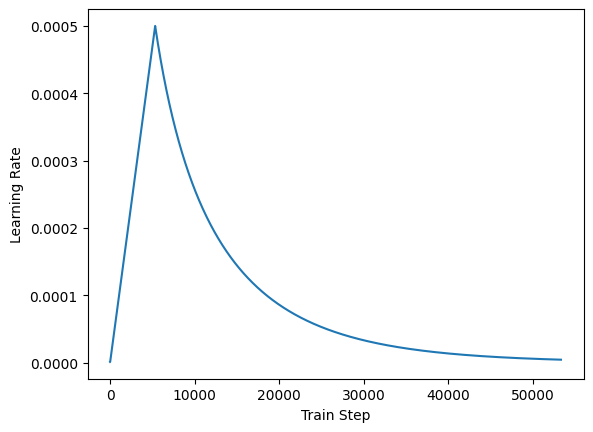

In [24]:
WARM_FRAC   = 0.1        # keep the fast ramp-up
DECAY_RATE  = 4
LR_FLOOR    = 1e-6
LR_PEAK_DESIRED = 5e-4     # choose 8e-4 or 9e-4

# pre-compute the scale that gives that peak
num_steps     = EPOCHS * len(text_pairs) // BATCH_SIZE
warmup_steps  = int(num_steps * WARM_FRAC)
current_peak  = 1.0 / tf.sqrt(tf.cast(d_model * warmup_steps, tf.float32))
LR_SCALE      = LR_PEAK_DESIRED / current_peak.numpy()

@tf.keras.utils.register_keras_serializable()   # so it can round-trip in SavedModel/H5
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, total_steps=num_steps,
                 warmup_frac=WARM_FRAC, decay_rate=DECAY_RATE,
                 lr_scale=LR_SCALE):
        super().__init__()
        self.d_model      = tf.cast(d_model, tf.float32)
        self.warmup_steps = tf.cast(int(total_steps * warmup_frac), tf.float32)
        self.decay_rate   = decay_rate
        self.decay_steps  = tf.cast(total_steps, tf.float32)
        self.lr_scale     = tf.cast(lr_scale, tf.float32)

    def __call__(self, step):
        step  = tf.cast(step, tf.float32)
        arg1  = tf.math.rsqrt(step)
        arg2  = step * tf.math.pow(self.warmup_steps, -1.5)
        warm  = tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
        decay = tf.math.exp(-self.decay_rate *
                            tf.maximum(step - self.warmup_steps, 0.) /
                            self.decay_steps)
        lr = warm * decay * self.lr_scale 
        return tf.maximum(lr, LR_FLOOR)

    # ----------  NEW  ----------
    def get_config(self):
        return {
            "d_model":      int(self.d_model.numpy()),   # cast back to Python types
            "total_steps":  int(self.decay_steps.numpy()),
            "warmup_frac":  float(self.warmup_steps.numpy() / self.decay_steps.numpy()),
            "decay_rate":   self.decay_rate,
            "lr_scale":     float(self.lr_scale.numpy()),
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9, clipnorm=1.0)

temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(num_steps, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

print(temp_learning_rate_schedule(tf.range(num_steps, dtype=tf.float32)))

In [25]:
ds_for_fit = ds.map(
    lambda b: (
        (tf.map_fn(decode_and_resize, b['img_path'], fn_output_signature=tf.float32), b["input_ids"]),
        b["labels"],
        b["loss_mask"]
    ),
    num_parallel_calls=tf.data.AUTOTUNE
)

# del(ds)

# 3) Compile with a standard sparse‐CE loss and let Keras use sample weights
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="mean_with_sample_weight"),
    metrics=["sparse_categorical_accuracy"]
)

# Build callbacks
callbacks = [
    EarlyStopping(monitor="loss", patience=3,
                  restore_best_weights=True, verbose=1),
    ModelCheckpoint(
        filepath="best_summary.keras",        # or "best_summary.h5"
        monitor="loss",
        save_best_only=True,
        verbose=1             # full model (weights + optimizer + LR schedule)
    )
]

# 4) Fit!  Keras will print epoch/step progress by default
history = model.fit(
    ds_for_fit,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1    # 1 = progress bar, loss & acc per epoch
)

Epoch 1/3
17789/17789 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - loss: 4.1653 - sparse_categorical_accuracy: 0.1268
Epoch 1: loss improved from inf to 3.27987, saving model to best_summary.keras
17789/17789 ━━━━━━━━━━━━━━━━━━━━ 11979s 672ms/step - loss: 4.1652 - sparse_categorical_accuracy: 0.1268
Epoch 2/3
17789/17789 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - loss: 2.5832 - sparse_categorical_accuracy: 0.1728
Epoch 2: loss improved from 3.27987 to 2.56137, saving model to best_summary.keras
17789/17789 ━━━━━━━━━━━━━━━━━━━━ 11863s 667ms/step - loss: 2.5832 - sparse_categorical_accuracy: 0.1728
Epoch 3/3
17789/17789 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - loss: 2.4849 - sparse_categorical_accuracy: 0.1750
Epoch 3: loss improved from 2.56137 to 2.48282, saving model to best_summary.keras
17789/17789 ━━━━━━━━━━━━━━━━━━━━ 11779s 662ms/step - loss: 2.4849 - sparse_categorical_accuracy: 0.1750
Restoring model weights from the end of the best epoch: 3.


In [121]:
def encode(text: str) -> list[int]:
    """
    Encodes the prompt for inference, creating a sequence that ends
    right after the [SEP] token, with NO PADDING.
    """
    # 1. Temporarily disable padding on the tokenizer
    tokenizer.no_padding()
    
    # 2. Encode the text. The post-processor will add [BOS] and [SEP].
    # This will return: [BOS, id, id, ..., SEP]
    text_ids = tokenizer.encode(text).ids
    
    # 3. IMPORTANT: Re-enable padding for any other part of your code that might need it
    tokenizer.enable_padding(pad_id=pad_id, pad_token='[PAD]', length=MAX_LEN)
    
    return text_ids

def generate_answer(image_path: str,
                    question:   str,
                    max_new_tokens: int = 30) -> str:
    
    img_token = tf.constant([image_path])
    img_token = tf.map_fn(decode_and_resize, img_token, fn_output_signature=tf.float32)
    
    # 1. Encode the prompt (image placeholders + question)
    # This creates: [IMG]...[IMG] [BOS] question [SEP]
    prompt_ids = encode(question)
    text_tokens = tf.constant([prompt_ids], dtype=tf.int32)
    
    # 2. Autoregressive loop
    for _ in range(max_new_tokens):
        # Use direct model call for performance (not model.predict)
        # Pass training=False
        logits = model((img_token, text_tokens), training=False)[:, -1, :] / 0.1
    
        # Sample the next token
        next_id = tf.random.categorical(logits, 1, dtype=tf.int32)

        # Append the new token
        text_tokens = tf.concat([text_tokens, next_id], 1)

        # Stop ONLY if EOS is generated
        if next_id[0, 0] == eos_id:
            break

    # 3. Decode the generated output
    generated_ids = text_tokens.numpy().tolist()[0] 

    print(generated_ids)
    
    # --- END FIX ---

    # Display image for context
    imgbgr = cv2.imread(image_path)
    if imgbgr is not None:
        imgrgb = cv2.cvtColor(imgbgr,cv2.COLOR_BGR2RGB)
        plt.imshow(imgrgb)
        plt.title(f"Q: {question}")
        plt.axis('off')
        plt.show()

    print(tokenizer.decode(generated_ids).strip())

[2, 173, 19, 202, 153, 56, 46, 68, 7, 4, 19, 103, 49, 19, 145, 303, 74, 188, 303, 1709, 861, 63, 19, 279, 170, 1629, 6, 46, 483, 1461, 766, 3]


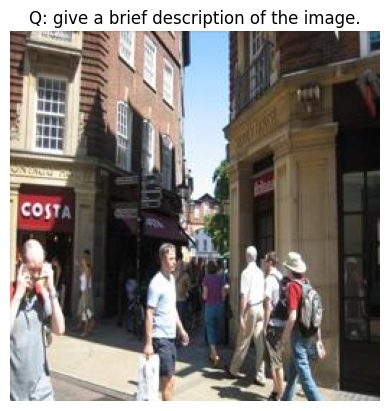

give a brief description of the image . a man in a white shirt and black shirt stands next to a sign that reads , the new york city
None


In [122]:
img   =  "GQA/resized_images/736.jpg"
ques  = "give a brief description of the image."
print(generate_answer(img, ques))

[2, 73, 82, 117, 244, 18, 4, 27, 244, 19, 1353, 7, 3]


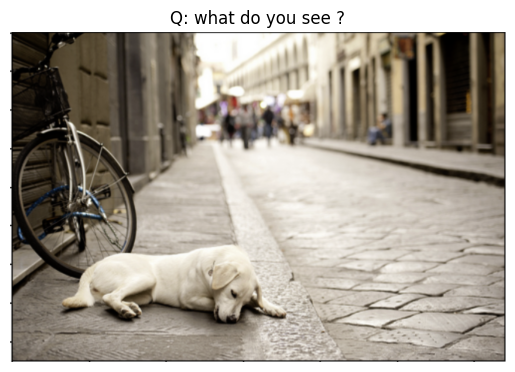

what do you see ? i see a bicycle .
None


In [53]:
img   =  "/Users/saptarshimallikthakur/Desktop/imgs/Screenshot 2025-06-08 at 7.36.42 AM.png"
ques  = "what do you see ?"
print(generate_answer(img, ques))

[2, 82, 117, 244, 115, 219, 18, 4, 107, 6, 69, 48, 19, 378, 7, 3]


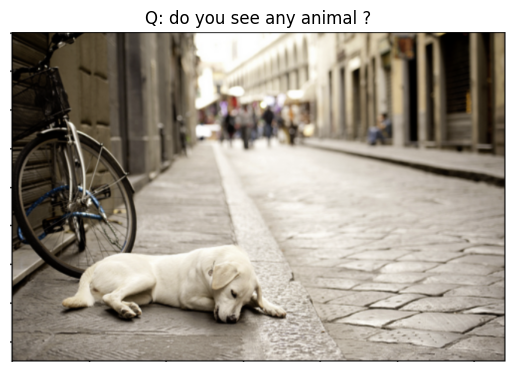

do you see any animal ? yes , there is a dog .
None


In [83]:
img   =  "/Users/saptarshimallikthakur/Desktop/imgs/Screenshot 2025-06-08 at 7.36.42 AM.png"
ques  = "do you see any animal ?"
print(generate_answer(img, ques))

[2, 73, 48, 46, 219, 803, 18, 4, 46, 219, 48, 1833, 7, 3]


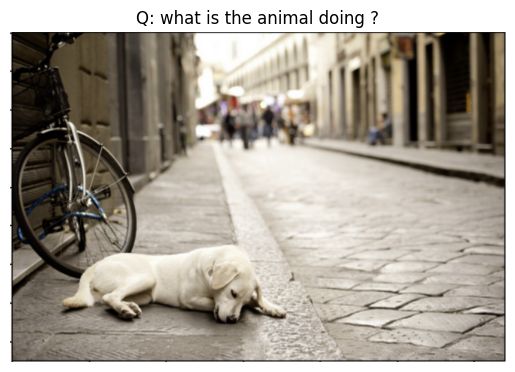

what is the animal doing ? the animal is sleeping .
None


In [64]:
img   =  "/Users/saptarshimallikthakur/Desktop/imgs/Screenshot 2025-06-08 at 7.36.42 AM.png"
ques  = "what is the animal doing ?"
print(generate_answer(img, ques))

[2, 73, 48, 46, 378, 803, 18, 4, 46, 378, 48, 1800, 862, 7, 3]


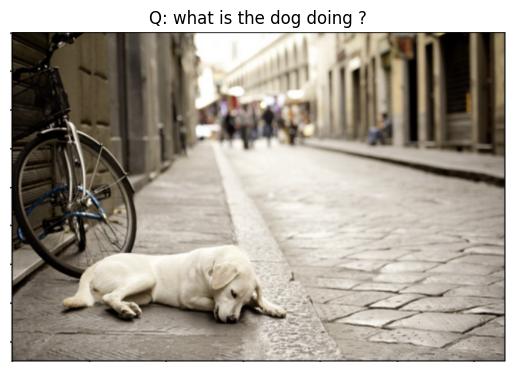

what is the dog doing ? the dog is laying down .
None


In [63]:
img   =  "/Users/saptarshimallikthakur/Desktop/imgs/Screenshot 2025-06-08 at 7.36.42 AM.png"
ques  = "what is the dog doing ?"
print(generate_answer(img, ques))

[2, 73, 48, 46, 534, 56, 46, 125, 18, 4, 46, 534, 56, 46, 125, 48, 769, 7, 3]


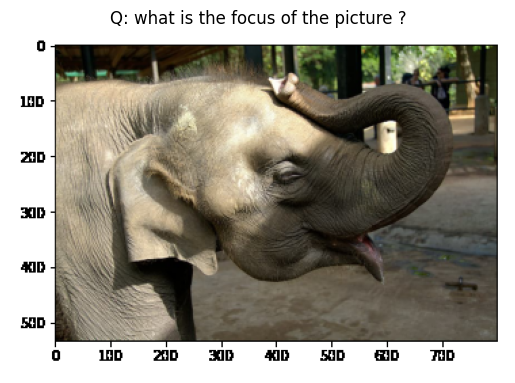

what is the focus of the picture ? the focus of the picture is elephant .
None


In [70]:
img   =  "/Users/saptarshimallikthakur/Desktop/imgs/download.png"
ques  = "what is the focus of the picture ?"
print(generate_answer(img, ques))

[2, 73, 48, 46, 149, 56, 46, 219, 18, 4, 46, 219, 48, 621, 7, 3]


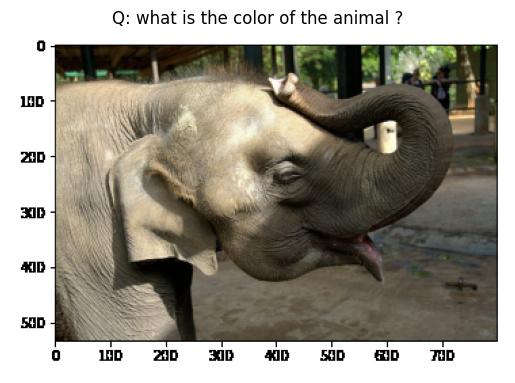

what is the color of the animal ? the animal is gray .
None


In [68]:
img   =  "/Users/saptarshimallikthakur/Desktop/imgs/download.png"
ques  = "what is the color of the animal ?"
print(generate_answer(img, ques))

[2, 73, 48, 46, 219, 803, 18, 4, 46, 219, 48, 591, 7, 3]


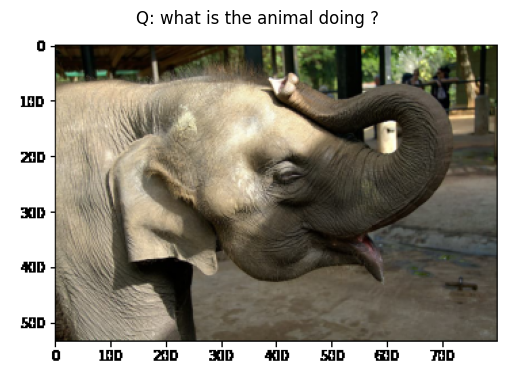

what is the animal doing ? the animal is standing .
None


In [59]:
img   =  "/Users/saptarshimallikthakur/Desktop/imgs/download.png"
ques  = "what is the animal doing ?"
print(generate_answer(img, ques))

[2, 319, 219, 48, 71, 18, 160, 322, 66, 69, 18, 4, 69, 48, 9, 750, 7, 3]


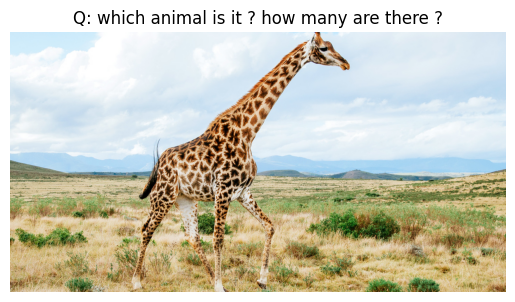

which animal is it ? how many are there ? there is 1 giraffe .
None


In [114]:
img   =  "/Users/saptarshimallikthakur/Desktop/imgs/girraffe.jpg"
ques  = "which animal is it ? how many are there ?"
print(generate_answer(img, ques))

[2, 319, 219, 48, 71, 18, 160, 322, 66, 69, 18, 4, 69, 48, 9, 378, 7, 3]


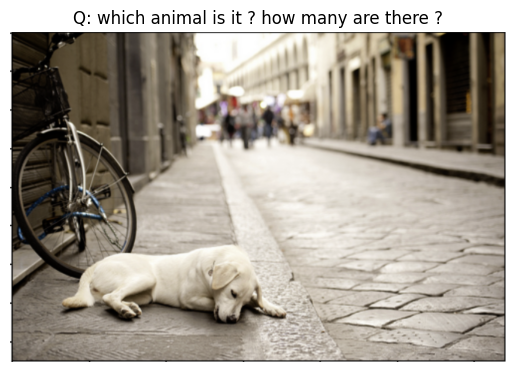

which animal is it ? how many are there ? there is 1 dog .
None


In [44]:
img   =  "/Users/saptarshimallikthakur/Desktop/imgs/Screenshot 2025-06-08 at 7.36.42 AM.png"
ques  = "which animal is it ? how many are there ?"
print(generate_answer(img, ques))

[2, 160, 322, 649, 66, 69, 18, 4, 69, 66, 10, 649, 7, 3]


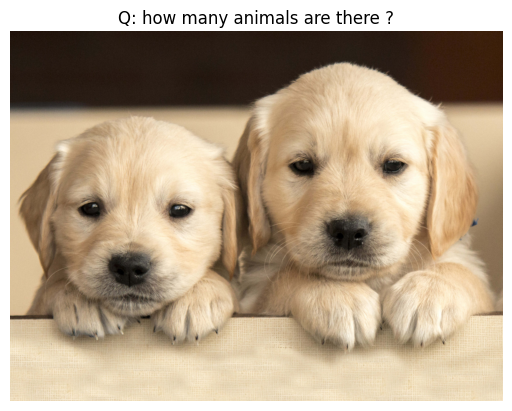

how many animals are there ? there are 2 animals .
None


In [71]:
img   =  "/Users/saptarshimallikthakur/Desktop/imgs/cutest-dog-breeds-jpg.jpg"
ques  = "how many animals are there ?"
print(generate_answer(img, ques))

[2, 73, 48, 46, 149, 56, 46, 219, 18, 4, 46, 219, 48, 145, 7, 3]


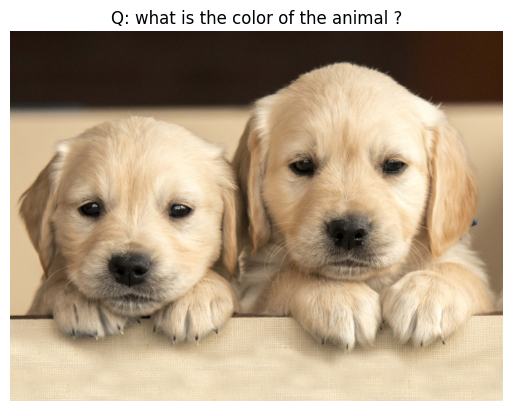

what is the color of the animal ? the animal is white .
None


In [82]:
img   =  "/Users/saptarshimallikthakur/Desktop/imgs/cutest-dog-breeds-jpg.jpg"
ques  = "what is the color of the animal ?"
print(generate_answer(img, ques))

[2, 73, 149, 82, 117, 244, 18, 4, 613, 7, 3]


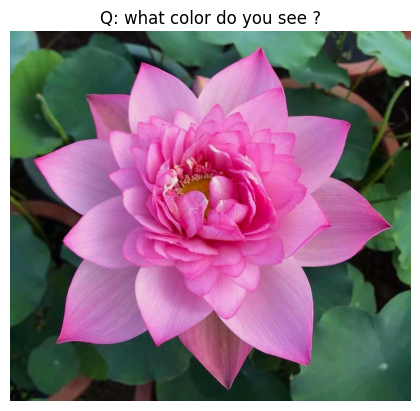

what color do you see ? pink .
None


In [72]:
img   =  "/Users/saptarshimallikthakur/Desktop/imgs/lotus.jpg"
ques  = "what color do you see ?"
print(generate_answer(img, ques))

[2, 174, 46, 68, 7, 4, 613, 810, 49, 46, 1247, 3]


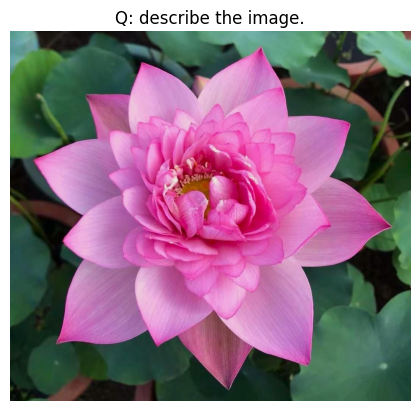

describe the image . pink flowers in the garden
None


In [75]:
img   =  "/Users/saptarshimallikthakur/Desktop/imgs/lotus.jpg"
ques  = "describe the image."
print(generate_answer(img, ques))

[2, 73, 48, 46, 1654, 504, 56, 46, 68, 18, 4, 46, 1654, 504, 56, 46, 68, 48, 891, 7, 3]


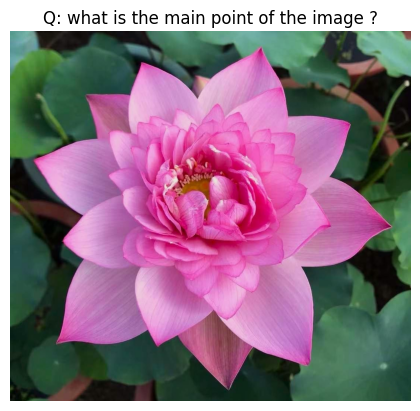

what is the main point of the image ? the main point of the image is flower .
None


In [80]:
img   =  "/Users/saptarshimallikthakur/Desktop/imgs/lotus.jpg"
ques  = "what is the main point of the image ?"
print(generate_answer(img, ques))

[2, 73, 82, 117, 244, 18, 4, 679, 7, 3]


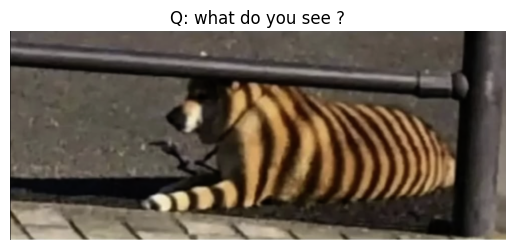

what do you see ? zebra .
None


In [123]:
img   =  "/Users/saptarshimallikthakur/Desktop/Screenshot 2025-06-11 at 10.33.22 AM.png"
ques  = "what do you see ?"
print(generate_answer(img, ques))